### In this notebook, we carry out clustering on the health data of different countries. We consider variables such as Infant mortality, fertility rate, physicians per thousand etc.

# Data Preparation

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
df = pd.read_csv("world-data-2023.csv") # Contains data of 195 countries across 35 variables (not all health related)
print(df.shape)
print(df.columns)
print("-"*100)
print(df.head)

(195, 35)
Index(['Country', 'Density\n(P/Km2)', 'Abbreviation', 'Agricultural Land( %)',
       'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Calling Code',
       'Capital/Major City', 'Co2-Emissions', 'CPI', 'CPI Change (%)',
       'Currency-Code', 'Fertility Rate', 'Forested Area (%)',
       'Gasoline Price', 'GDP', 'Gross primary education enrollment (%)',
       'Gross tertiary education enrollment (%)', 'Infant mortality',
       'Largest city', 'Life expectancy', 'Maternal mortality ratio',
       'Minimum wage', 'Official language', 'Out of pocket health expenditure',
       'Physicians per thousand', 'Population',
       'Population: Labor force participation (%)', 'Tax revenue (%)',
       'Total tax rate', 'Unemployment rate', 'Urban_population', 'Latitude',
       'Longitude'],
      dtype='object')
----------------------------------------------------------------------------------------------------
<bound method NDFrame.head of          Country Density\n(P/Km2) Ab

#### Extracting the health related data

In [3]:
health_variables = ['Birth Rate', 'Fertility Rate', 'Infant mortality', 'Life expectancy', 'Maternal mortality ratio', 'Out of pocket health expenditure', 'Physicians per thousand']
health_df = df[['Country', 'Abbreviation'] + health_variables]

In [4]:
print(health_df.columns)
print("-"*100)
print(health_df.head)

Index(['Country', 'Abbreviation', 'Birth Rate', 'Fertility Rate',
       'Infant mortality', 'Life expectancy', 'Maternal mortality ratio',
       'Out of pocket health expenditure', 'Physicians per thousand'],
      dtype='object')
----------------------------------------------------------------------------------------------------
<bound method NDFrame.head of          Country Abbreviation  Birth Rate  Fertility Rate  Infant mortality  \
0    Afghanistan           AF       32.49            4.47              47.9   
1        Albania           AL       11.78            1.62               7.8   
2        Algeria           DZ       24.28            3.02              20.1   
3        Andorra           AD        7.20            1.27               2.7   
4         Angola           AO       40.73            5.52              51.6   
..           ...          ...         ...             ...               ...   
190    Venezuela           VE       17.88            2.27              21.4   
191 

#### Removing records with missing data (this will mean some countries will not be considered in clustering and will be grayed out in visualisation)

In [5]:
nan_rows = health_df.isnull().any(axis=1)
print(len(nan_rows))

195


In [6]:
print(health_df[nan_rows])

                            Country Abbreviation  Birth Rate  Fertility Rate  \
3                           Andorra           AD        7.20            1.27   
39            Republic of the Congo          NaN       32.86            4.43   
42                             Cuba           CU       10.17            1.62   
48                         Dominica           DM       12.00            1.90   
56                         Eswatini          NaN         NaN             NaN   
73                     Vatican City          NaN         NaN             NaN   
81              Republic of Ireland          NaN       12.50            1.75   
98                    Liechtenstein           LI        9.90            1.44   
107                Marshall Islands           MH       29.03            4.05   
113                          Monaco           MC        5.90             NaN   
119                         Namibia          NaN       28.64            3.40   
120                           Nauru     

In [7]:
health_df.dropna(inplace=True)

/tmp/ipykernel_15373/3069228532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_df.dropna(inplace=True)


In [8]:
print(health_df.shape)
print(health_df.isnull().any(axis=1).sum())

(174, 9)
0


#### Mapping % variable to range [0, 1]

In [9]:
health_df['Out of pocket health expenditure'] = health_df['Out of pocket health expenditure'].str.rstrip('%').astype(float) / 100

/tmp/ipykernel_15373/498667147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_df['Out of pocket health expenditure'] = health_df['Out of pocket health expenditure'].str.rstrip('%').astype(float) / 100


In [10]:
print(health_df.head)

<bound method NDFrame.head of                  Country Abbreviation  Birth Rate  Fertility Rate  \
0            Afghanistan           AF       32.49            4.47   
1                Albania           AL       11.78            1.62   
2                Algeria           DZ       24.28            3.02   
4                 Angola           AO       40.73            5.52   
5    Antigua and Barbuda           AG       15.33            1.99   
..                   ...          ...         ...             ...   
190            Venezuela           VE       17.88            2.27   
191              Vietnam           VN       16.75            2.05   
192                Yemen           YE       30.45            3.79   
193               Zambia           ZM       36.19            4.63   
194             Zimbabwe           ZW       30.68            3.62   

     Infant mortality  Life expectancy  Maternal mortality ratio  \
0                47.9             64.5                     638.0   
1    

In [11]:
print(health_df.isnull().any(axis=1).sum()) # no null values introduced in mapping percentage

0


In [12]:
summary_stats = health_df.describe().loc[['mean', 'min', '25%', '75%', 'max']]
print(summary_stats)

      Birth Rate  Fertility Rate  Infant mortality  Life expectancy  \
mean   20.392989        2.696207         21.216092        72.357471   
min     6.400000        0.980000          1.400000        52.800000   
25%    11.425000        1.710000          6.100000        67.375000   
75%    28.625000        3.585000         32.475000        77.375000   
max    46.080000        6.910000         84.500000        84.200000   

      Maternal mortality ratio  Out of pocket health expenditure  \
mean                151.431034                          0.332299   
min                   2.000000                          0.002000   
25%                  12.250000                          0.178250   
75%                 181.500000                          0.449500   
max                1140.000000                          0.816000   

      Physicians per thousand  
mean                 1.769023  
min                  0.010000  
25%                  0.310000  
75%                  2.860000  
max 

### Normalising variable values to [0, 1] so no variable overpowers clustering

In [13]:
normalized_vars = health_df[health_variables].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
norm_health_df = pd.concat([health_df[['Country', 'Abbreviation']], normalized_vars], axis=1)
norm_health_df.head

<bound method NDFrame.head of                  Country Abbreviation  Birth Rate  Fertility Rate  \
0            Afghanistan           AF    0.657510        0.588533   
1                Albania           AL    0.135585        0.107926   
2                Algeria           DZ    0.450605        0.344013   
4                 Angola           AO    0.865171        0.765599   
5    Antigua and Barbuda           AG    0.225050        0.170320   
..                   ...          ...         ...             ...   
190            Venezuela           VE    0.289315        0.217538   
191              Vietnam           VN    0.260837        0.180438   
192                Yemen           YE    0.606099        0.473862   
193               Zambia           ZM    0.750756        0.615514   
194             Zimbabwe           ZW    0.611895        0.445194   

     Infant mortality  Life expectancy  Maternal mortality ratio  \
0            0.559567         0.372611                  0.558875   
1    

#### Investigating distrbution of data to determine if min-max normalisation is reasonable or if another normalisation must be used

In [14]:
summary_stats = norm_health_df.describe().loc[['mean', 'min', '25%', '75%', 'max']]
print(summary_stats)

      Birth Rate  Fertility Rate  Infant mortality  Life expectancy  \
mean    0.352646        0.289411          0.238461         0.622849   
min     0.000000        0.000000          0.000000         0.000000   
25%     0.126638        0.123103          0.056558         0.464172   
75%     0.560106        0.439292          0.373947         0.782643   
max     1.000000        1.000000          1.000000         1.000000   

      Maternal mortality ratio  Out of pocket health expenditure  \
mean                  0.131310                          0.405773   
min                   0.000000                          0.000000   
25%                   0.009007                          0.216523   
75%                   0.157733                          0.549754   
max                   1.000000                          1.000000   

      Physicians per thousand  
mean                 0.247401  
min                  0.000000  
25%                  0.042194  
75%                  0.400844  
max 

Each variable seems to show reasonable distribution so we stick with min-max normalisation

## SOM

In [15]:
num_vars = len(health_variables)
K = 10
J = 10

### Initialise

In [16]:
# Making an KxJ grid of neurons where each neuron has num_vars (7) weights. We use random initialisation
SOM = np.random.rand(K, J, num_vars)

### Visualise

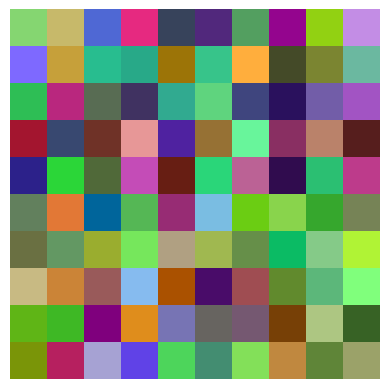

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualise_som(SOM): # to visualise, we reduce our 7 dimensional weights to 3 dimensions, where each can represent the intensity of the (R, G, B) channels respectively
    n_components = 3
    pca = PCA(n_components=n_components)
    
    # Reshape the SOM to (height * width, features)
    X = SOM.reshape(SOM.shape[0] * SOM.shape[1], -1)
    
    # Apply PCA
    X_fit = pca.fit_transform(X)
    
    # Min-max normalization: scale each channel (RGB) to [0, 1]
    X_min = X_fit.min(axis=0)  # min per component (RGB)
    X_max = X_fit.max(axis=0)  # max per component (RGB)
    X_fit = (X_fit - X_min) / (X_max - X_min)  # Normalize each component
    
    # Reshape back to SOM grid (height, width, n_components)
    X_fit = X_fit.reshape(SOM.shape[0], SOM.shape[1], n_components)
    
    # Plot the SOM as an RGB image
    plt.imshow(X_fit)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
    return X_fit

# View initial grid
_ = visualise_som(SOM)

### Functions that enable our SOM to learn

In [18]:
def get_best_match(SOM, record_values): # Find best matching neuron by taking distance with all and identifying neuron with least distance - return distance and neuron location (row, column)
    distances = np.linalg.norm(SOM - record_values, axis=2) # Using numpy broadcasting for efficient calculation
    min_row, min_col = np.unravel_index(np.argmin(distances), distances.shape)
    min_dist = distances[min_row][min_col]
    return min_dist, min_row, min_col

In [19]:
def update_weights(SOM, record_values, min_row, min_col, cur_lr, cur_radius): # Update weight based on the position of current neuron and best matching neuron
    for i in range(SOM.shape[0]):
        for j in range(SOM.shape[1]):
            dist = np.linalg.norm((min_row - i, min_col - j))
            h = cur_lr * (np.exp( -(np.square(dist)) / (2*np.square(cur_radius)) )) # Formula taken from book - determines degree of influence based on distance and neighbourhood radius
            SOM[i][j] += h*(record_values - SOM[i][j]) # Update weight

#### Hyperparameters

In [20]:
init_lr = 1e-3 # initial learning rate
lr_decay = 0.9 # learning rate decay
init_radius = K/2 # initial neighbourhood radius
radius_decay = 0.9 # neighbourhood radius decay

### Train SOM on data

Epoch: 0/100 - Average error: 0.5508524185153455
Epoch: 1/100 - Average error: 0.5143277019508473
Epoch: 2/100 - Average error: 0.4852090824715444
Epoch: 3/100 - Average error: 0.4632131960680204
Epoch: 4/100 - Average error: 0.44760058493877336
Epoch: 5/100 - Average error: 0.43787957240725744
Epoch: 6/100 - Average error: 0.432912236478729
Epoch: 7/100 - Average error: 0.43051474317939925
Epoch: 8/100 - Average error: 0.42925766078118066
Epoch: 9/100 - Average error: 0.4280827771317762
Epoch: 10/100 - Average error: 0.4262725136455364
Epoch: 11/100 - Average error: 0.4231299839098091
Epoch: 12/100 - Average error: 0.4192054249479379
Epoch: 13/100 - Average error: 0.41540751959449945
Epoch: 14/100 - Average error: 0.41192085248511295
Epoch: 15/100 - Average error: 0.4084950625462291
Epoch: 16/100 - Average error: 0.4052304331255284
Epoch: 17/100 - Average error: 0.4019404431260298
Epoch: 18/100 - Average error: 0.39861185123692683
Epoch: 19/100 - Average error: 0.3955180075578097
Epoc

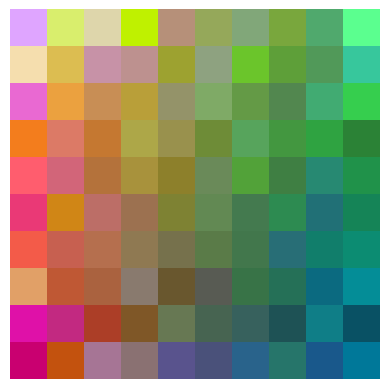

Epoch: 30/100 - Average error: 0.3676391377425265
Epoch: 31/100 - Average error: 0.3637107923449476
Epoch: 32/100 - Average error: 0.35999002713199807
Epoch: 33/100 - Average error: 0.3564828870100792
Epoch: 34/100 - Average error: 0.35319644835373937
Epoch: 35/100 - Average error: 0.3501040808968906
Epoch: 36/100 - Average error: 0.3472350138237657
Epoch: 37/100 - Average error: 0.34453200924052696
Epoch: 38/100 - Average error: 0.34204058524423697
Epoch: 39/100 - Average error: 0.33969656348681104
Epoch: 40/100 - Average error: 0.33740644260356567
Epoch: 41/100 - Average error: 0.33524393487821424
Epoch: 42/100 - Average error: 0.3331724754013009
Epoch: 43/100 - Average error: 0.3311606616531583
Epoch: 44/100 - Average error: 0.32919295993849734
Epoch: 45/100 - Average error: 0.3273007420949277
Epoch: 46/100 - Average error: 0.32548551450415897
Epoch: 47/100 - Average error: 0.32376641580328674
Epoch: 48/100 - Average error: 0.32211715800083396
Epoch: 49/100 - Average error: 0.320541

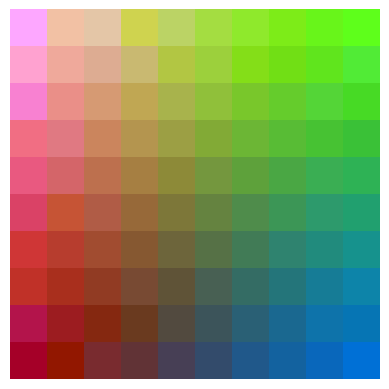

Epoch: 60/100 - Average error: 0.30629796990853747
Epoch: 61/100 - Average error: 0.3045807937142392
Epoch: 62/100 - Average error: 0.30295889854899255
Epoch: 63/100 - Average error: 0.3014075712350439
Epoch: 64/100 - Average error: 0.2999300827983129
Epoch: 65/100 - Average error: 0.2985239594260039
Epoch: 66/100 - Average error: 0.29719463286454345
Epoch: 67/100 - Average error: 0.29591011550452306
Epoch: 68/100 - Average error: 0.29465527442420786
Epoch: 69/100 - Average error: 0.293459620200369
Epoch: 70/100 - Average error: 0.29231382056556376
Epoch: 71/100 - Average error: 0.2912225637487073
Epoch: 72/100 - Average error: 0.29019592452234794
Epoch: 73/100 - Average error: 0.28922517689258653
Epoch: 74/100 - Average error: 0.2883076568606754
Epoch: 75/100 - Average error: 0.2874294306099733
Epoch: 76/100 - Average error: 0.28658888306784386
Epoch: 77/100 - Average error: 0.28578358957932737
Epoch: 78/100 - Average error: 0.2850144537641362
Epoch: 79/100 - Average error: 0.28428796

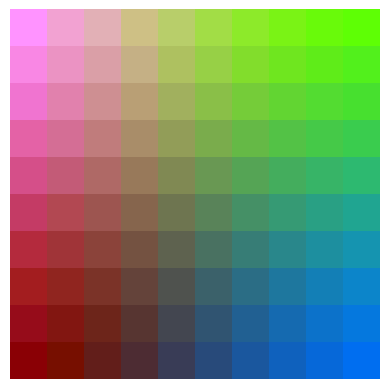

Epoch: 90/100 - Average error: 0.27763069355484693
Epoch: 91/100 - Average error: 0.2766485238489153
Epoch: 92/100 - Average error: 0.27571272279046577
Epoch: 93/100 - Average error: 0.2748116826506168
Epoch: 94/100 - Average error: 0.27395406686289475
Epoch: 95/100 - Average error: 0.2731343710336729
Epoch: 96/100 - Average error: 0.2723527937891958
Epoch: 97/100 - Average error: 0.2716132301088103
Epoch: 98/100 - Average error: 0.2709081927971983
Epoch: 99/100 - Average error: 0.27022752104600867


In [21]:
num_epochs = 100 # number of epochs to run for - terminating condition
cur_lr = init_lr
cur_radius = init_radius
for epoch in range(num_epochs):
    quant_error = 0
    for idx, record in norm_health_df.iloc[:].iterrows():
        record_values = np.asarray(record[health_variables].values, dtype=np.float64)
        min_dist, min_row, min_col = get_best_match(SOM, record_values)
        quant_error += min_dist
        # print(f"Record index: {idx}, Nearest SOM element at (row, col): ({min_row}, {min_col})")

        update_weights(SOM, record_values, min_row, min_col, cur_lr, cur_radius)
        
    quant_error = quant_error / norm_health_df.shape[0]
    print(f"Epoch: {epoch}/{num_epochs} - Average error: {quant_error}")

    if (epoch+1) % 30 == 0:
        visualise_som(SOM)
        cur_lr *= lr_decay
        cur_radius *= radius_decay


### Final SOM Grid

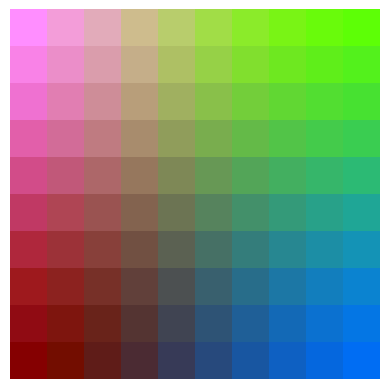

In [22]:
clusters = visualise_som(SOM) # Get colors of grid
# print(clusters)

### Visualising on World Map

In [23]:
print(norm_health_df['Abbreviation'])

0      AF
1      AL
2      DZ
4      AO
5      AG
       ..
190    VE
191    VN
192    YE
193    ZM
194    ZW
Name: Abbreviation, Length: 174, dtype: object


In [24]:
!pip install geopandas

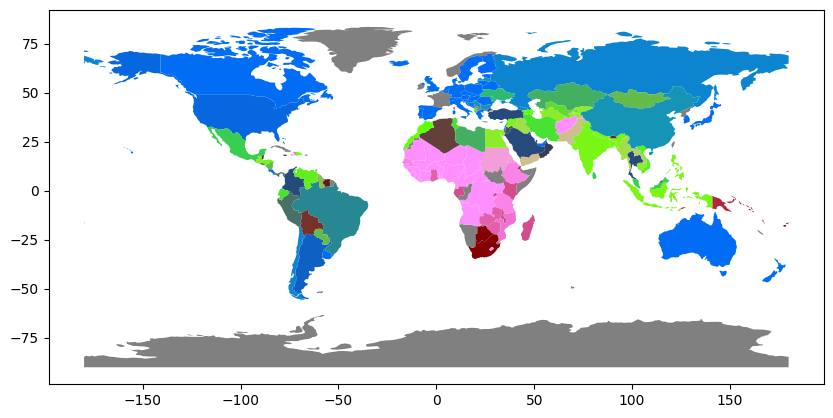

In [25]:
import geopandas as gpd

# Load GeoDataFrame for world map
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
colors = []

for iso in world['ISO_A2']:
    if iso in norm_health_df['Abbreviation'].values: # Abbreviation contains iso_a2 -> coloring those countries that I have data for
        record_values = norm_health_df[norm_health_df['Abbreviation'] == iso]
        record_values = np.asarray(record_values[health_variables].values, dtype=np.float64)
        _, best_row, best_col = get_best_match(SOM, record_values)
        rgb_color = clusters[best_row, best_col]
        colors.append(rgb_color)
    else:
        # If no match is found, color gray
        colors.append([0.5, 0.5, 0.5])

# Assign colors to the world map based on countries
world['color'] = colors

# Plot the world map with the RGB colors
ax = world.plot(color=world['color'], figsize=(10, 6))

# Show the plot
plt.show()


From this visualisation, we see that countries which are normally considered developed seem to have similar healthcare systems. Moreover, countries within the same region tend to have similar health conditions, which is what we expect. One key observation is that Pakistan is anomolous within its own region.